# <center>Initial stage of the novel Coronavirus Disease 2019 epidemics outbreak analytical modeling</center>
## <center>Case of The Republic of Croatia</center>

<center>
    Ante Lojic Kapetanovic <br>
    <a href="alojic00@fesb.hr">alojic00@fesb.hr</a> <br>
    Faculty of electrical engineering, mechanical engineering and naval architecture <br>
    University of Split <br>
    Split, Croatia
</center>

**Description** $-$ This report overviews different analytical techniques to tackle the problem of the initial stage Coronavirus Disease 2019 (COVID-19) modeling. Using the data on confirmed infections in the closed territory of the Republic of Croatia, both exponential and logistic fitting has been performed on the different stages of the epidemics. Deriving only the time series of active infections from the total daily number of newly confirmed infected individuals, the cumulative number of recovered (expected recovery rate, $\gamma = 1/15$) and the cumulative number of deceased individuals due to infection, Heidler function fitting has been performed for the complete duration of the first epidemic *wave*. Results show that logistic and Heidler function achieve exceptional goodness-of-fit for the cumulative number of confirmed cases and the active number of confirmed cases, respectively, for the complete duration of the first epidemic *wave*. Exponential fit, however, successfully fits only a very short period of the initial outbreak from Feb, $25^{th}$ to Mar, $18^{th}$ when the curve growth for the cumulative number of confirmed cases takes on a linear characteristic.

**Keywords** $-$ Coronavirus disease 2019, initial outbreak modeling, exponential function, logistic function, Heidler function, least-squares optimization

**Software** $-$ Ubuntu 18.04 LTS, Python 3.7.6, CoroPy package

In [1]:
# LIB IMPORTS
import os
import datetime

from coropy.growth_models import GrowthCOVIDModel
from matplotlib import dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

import plotting

In [2]:
np.random.seed(42)  # for reproducibility

In [3]:
plotting.configure()  # paper-quality plots

blue = plotting.default_colors('blue')
purple = plotting.default_colors('purple')

In [4]:
# all data
DATA_DIR = 'data'
FILE_NAME = '1st_wave_data_cro.csv' 
FILE_PATH = os.path.join(os.pardir, DATA_DIR, FILE_NAME)
df = pd.read_csv(FILE_PATH)

# derived data
cum_positives = np.cumsum(df.confirmed_positives.values)
cum_recovered = df.estimate_recovered.values
cum_deceased = np.cumsum(df.confirmed_deceased.values)
active = cum_positives - cum_recovered - cum_deceased

## 1 Logistic fitting

$$
f(x) = \frac{a}{1 + e^{-c \cdot (x - d) + b}}
$$

Logistic function normalized parameters 
--------------------------------------- 
x ∈ [0, 1] and y ∈ [0, 1] where y=f(x) 
--------------------------------------- 
a = 1.022459500784719
b = -0.03874645087859409
c = 11.947786133148481
d = 0.3851305638848217

goodness-of-fit 
--------------- 
S = 45.04810968930362
R2 = 0.9975292056555135



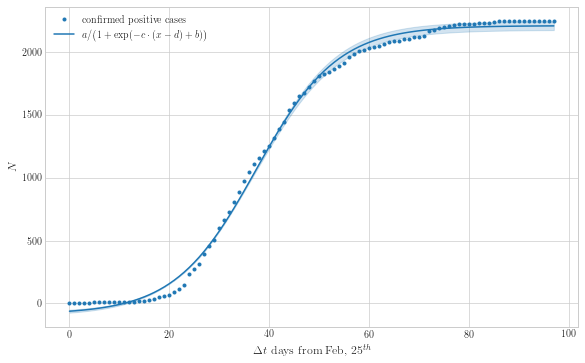

In [5]:
# fit the entire first wave data to a logistic model
model = GrowthCOVIDModel('logistic', normalize=True, calc_ci=True)
model.fit(cum_positives)
x, fitted = model.get_fitted

# printout
sre = np.sqrt(np.mean((cum_positives - fitted[1])**2))
r2 = r2_score(cum_positives, fitted[1])
a, b, c, d = model.get_params
print(
    f'Logistic function normalized parameters \n'
    f'--------------------------------------- \n'
    f'x ∈ [0, 1] and y ∈ [0, 1] where y=f(x) \n'
    f'--------------------------------------- \n'
    f'a = {a}\n'
    f'b = {b}\n'
    f'c = {c}\n'
    f'd = {d}\n'
    f'\n'
    f'goodness-of-fit \n'
    f'--------------- \n'
    f'S = {sre}\n'
    f'R2 = {r2}\n'
    )

# visualize
fig = plt.figure()
ax = fig.subplots(nrows=1, ncols=1)
ax.plot(x, cum_positives, '.', color=blue, label='confirmed positive cases')
ax.plot(x, fitted[1], '-', color=blue, label=r'$a / \big( 1 + \exp (-c \cdot (x - d) + b ) \big)$')
ax.fill_between(x, fitted[0], fitted[2], color=blue, alpha=0.2)
ax.set_xlabel(r'$\Delta t$ days from Feb, $25^{th}$')
ax.set_ylabel(r'$N$')
ax.legend()
plt.show()
fname = f'cumulative_positives-sigmoidal_fit'
fig.savefig(fname=os.path.join('output', 'figs', fname + '.pdf'), format='pdf', bbox_inches='tight')

## 2 Heidler fitting

$$
f(x) = \frac{a}{b} \cdot \Big( 1 - e^{-\frac{t}{t_1}} \Big) \cdot \Big( \big(1 - e^{-\frac{t}{t_1}} \big)^n \cdot e^{-\frac{t}{t_2}} \Big)
$$

Heidler function normalized parameters 
--------------------------------------- 
x ∈ [0, 1] and y ∈ [0, 1] where y=f(x) 
--------------------------------------- 
t1 = 0.24952021394111706
t2 = 0.11131166755475279
n = 13.013372460513825
a = 6.630595334666665
b = 0.011795450194024481

goodness-of-fit 
--------------- 
S = 25.16100357006354
R2 = 0.9967973613107606



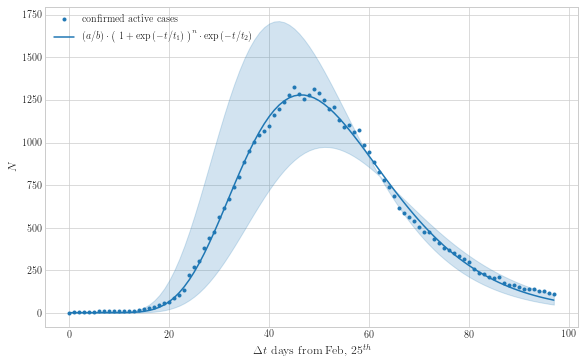

In [6]:
# fit the entire first wave data to a Heidler function
def heidler(t, t1, t2, n, a, b):
    exp_1 = 1 - np.exp(-t/t1)
    exp_2 = np.exp(-t/t2)
    # if np.sign is not used NumPy will generate RuntimeWarning: invalid value encountered in power
    # https://stackoverflow.com/questions/45384602/numpy-runtimewarning-invalid-value-encountered-in-power#45384691
    return a/b * np.sign(exp_1) * (np.abs(exp_1))**n * exp_2  

model = GrowthCOVIDModel(heidler, normalize=True, calc_ci=True)
model.fit(active)
x, fitted = model.get_fitted

# prinout
sre = np.sqrt(np.mean((active - fitted[1])**2))
r2 = r2_score(active, fitted[1])
t1, t2, n, a, b = model.get_params
print(
    f'Heidler function normalized parameters \n'
    f'--------------------------------------- \n'
    f'x ∈ [0, 1] and y ∈ [0, 1] where y=f(x) \n'
    f'--------------------------------------- \n'
    f't1 = {t1}\n'
    f't2 = {t2}\n'
    f'n = {n}\n'
    f'a = {a}\n'
    f'b = {b}\n'
    f'\n'
    f'goodness-of-fit \n'
    f'--------------- \n'
    f'S = {sre}\n'
    f'R2 = {r2}\n'
    )

# visualize
fig = plt.figure()
ax = fig.subplots(nrows=1, ncols=1)
ax.plot(x, active, '.', color=blue, label='confirmed active cases')
ax.plot(x, fitted[1], '-', color=blue, label=r'$(a/b) \cdot \big(~1+\exp(-t/t_1)~ \big)^n \cdot \exp(-t/t_2)$')
ax.fill_between(x, fitted[0], fitted[2], color=blue, alpha=0.2)
ax.set_xlabel(r'$\Delta t$ days from Feb, $25^{th}$')
ax.set_ylabel(r'$N$')
ax.legend(loc='upper left')
plt.show()
fname = f'active_positives-heidler_fit'
fig.savefig(fname=os.path.join('output', 'figs', fname + '.pdf'), format='pdf', bbox_inches='tight')

## Exponential fitting

$$
f(x) = a \cdot e^{b x} + c
$$

Exponential function normalized parameters 
------------------------------------------ 
x ∈ [0, 1] and y ∈ [0, 1] where y=f(x) 
------------------------------------------ 
a = 0.0054443517063630185
b = 5.181405809972241
c = 0.031420600713991775

goodness-of-fit 
--------------- 
[fitted] S = 2.1150563884251046
[fitted] R2 = 0.9917348141643625
[extrapolated] S = 131.4712434180544
[extrapolated] R2 = 0.45287094118060733



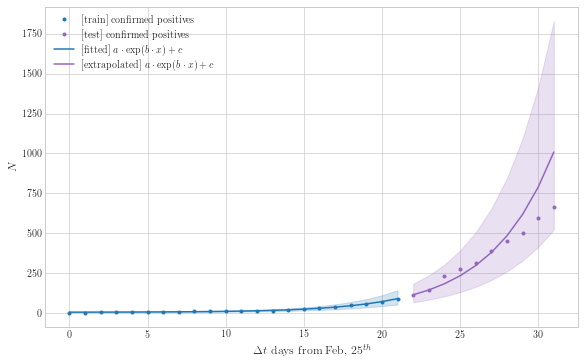

In [7]:
start_date = datetime.datetime(2020, 2, 25)
end_critical = datetime.datetime(2020, 3, 18)
dur_critical = (end_critical - start_date).days
n_days_future = 10
y_train, y_test = cum_positives[:dur_critical], cum_positives[dur_critical:dur_critical+n_days_future]

# fit the critical initial period to model and evaulate the extrapolation performance
model = GrowthCOVIDModel('exponential', normalize=True, calc_ci=True)
model.fit(y_train)
x_fit, y_fit = model.get_fitted
x_pred, y_pred = model.predict(n_days_future)

# prinout
sre_fit = np.sqrt(np.mean((y_train - y_fit[1])**2))
r2_fit = r2_score(y_train, y_fit[1])
sre_predict = np.sqrt(np.mean((y_test - y_pred[1])**2))
r2_predict = r2_score(y_test, y_pred[1])
a, b, c = model.get_params
print(
    f'Exponential function normalized parameters \n'
    f'------------------------------------------ \n'
    f'x ∈ [0, 1] and y ∈ [0, 1] where y=f(x) \n'
    f'------------------------------------------ \n'
    f'a = {a}\n'
    f'b = {b}\n'
    f'c = {c}\n'
    f'\n'
    f'goodness-of-fit \n'
    f'--------------- \n'
    f'[fitted] S = {sre_fit}\n'
    f'[fitted] R2 = {r2_fit}\n'
    f'[extrapolated] S = {sre_predict}\n'
    f'[extrapolated] R2 = {r2_predict}\n'
    )

# visualize
fig = plt.figure()
ax = fig.subplots(nrows=1, ncols=1)
ax.plot(x_fit, y_train, '.', color=blue, label='[train] confirmed positives')
ax.plot(x_pred, y_test, '.', color=purple, label='[test] confirmed positives')
ax.plot(x_fit, y_fit[1], '-', color=blue, label='[fitted] $a \cdot \exp(b \cdot x) + c$')
ax.fill_between(x_fit, y_fit[0], y_fit[2], color=blue, alpha=0.2)
ax.plot(x_pred, y_pred[1], '-', color=purple, label='[extrapolated] $a \cdot \exp(b \cdot x) + c$')
ax.fill_between(x_pred, y_pred[0], y_pred[2], color=purple, alpha=0.2)
ax.set_xlabel(r'$\Delta t$ days from Feb, $25^{th}$')
ax.set_ylabel(r'$N$')
ax.legend(loc='upper left')
plt.show()
fname = f'cumulative_positives-exponential_fit-{n_days_future}_days_extrapolation'
fig.savefig(fname=os.path.join('output', 'figs', fname + '.pdf'), format='pdf', bbox_inches='tight')